# 从全连接到卷积

全连接层主要存在以下问题：
1. 在使用全连接层处理图像数据时，需要先将图像展平为1维数组，然后再对进行相关的计算，这样做忽略了每个图像的空间结构信息。
2. 全连接层需要将上下两层的神经元全部相连接，这样会导致参数量非常多。举个例子：图像大小是$100\times100$的图像，再输入隐藏层神经元数量为50的网络中时，产生的权重参数量为$100\times100\times50=500\enspace000$

卷积操作主要有以下两个特性：
1. 平移不变性：不够检测对象出现再图像中的哪个位置，神经网络的前面几层应该对相同的图像区域具有相似的反应，即为“平移不变性”。
2. 局部性：神经网络的前面几层应该只探索输入图像中的局部区域，而不过度在意图像中相隔较远的区域的关系，这就是“局部性”原则。最终，可以聚合这些局部特征，以在整个图像级别进行预测。

# 图像卷积

## 互相关运算

严格来说，卷积层是个错误的叫法，因为它所表达的运算其实是互相关运算，而不是卷积运算。

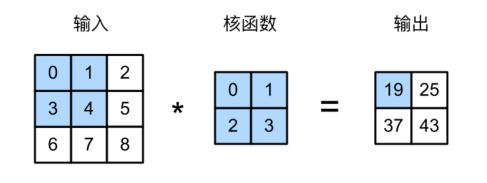

输出特征图的大小为$(n_h-k_h+1)\times(n_w-k_w+1)$<br>
其中：
- $n_h$为原始图像高度
- $n_w$为原始图像宽度
- $k_h$为卷积核高度
- $k_w$为卷积核宽度

In [13]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X, K):  #@save
    """计算二位互相关运算"""
    Y = torch.zeros((X.shape[0]-K.shape[0]+1, X.shape[1]-K.shape[1]+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+K.shape[0], j:j+K.shape[1]] * K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 卷积层

基于上面定义的corr2d函数实现二维卷积层。在`__init__`构造函数中，将weight和bias声明为两个模型参数，前向传播函数调用corr2d函数并添加偏置。

In [18]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1,))
        
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

使用$2\times2$的卷积核对$X$进行卷积

In [19]:
Conv2D((2, 2))(X)

tensor([[2.8595, 4.4158],
        [7.5284, 9.0847]], grad_fn=<AddBackward0>)

## 图像中的边缘检测

首先我们构造一个6$\times$8像素的黑白图像。中间四列为黑色(0)，其余像素为白色(1)。

In [20]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

接下来我们构造一个高度为1，宽度为2的卷积核

In [21]:
K = torch.tensor([[1.0, -1.0]])

In [23]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

其中1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘

接下来将图像进行转置，再次使用上方的卷积核K进行边缘检测

In [25]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

我们发现卷积核K只能够检测出垂直边缘，水平边缘无法检测到。

## 学习卷积核

如果我们只需寻找黑白边缘，那么以上$[1, -1]$的边缘检测器足以。然而，当有了更复杂数值的卷积核，或者连续的卷积层时，我们不可能手动设计滤波器。那么我们是否可以学习由X生成Y的卷积核呢?<br>
现在让我们看看是否可以通过仅查看“输入-输出”对来学习由X生成Y的卷积核。我们先构造⼀个卷积层，并将其卷积核初始化为随机张量。接下来，在每次迭代中，我们⽐较Y与卷积层输出的平⽅误差，然后计算梯度来更新卷积核。为了简单起⻅，我们在此使⽤内置的⼆维卷积层，并忽略偏置。

In [33]:
# 构造一个二维卷积层，它具有1个输出通道和形状为(1, 2)的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式(批量大小，通道，高度，宽度)
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch{i+1}, loss{l.sum():.3f}')

epoch2, loss1.894
epoch4, loss0.345
epoch6, loss0.069
epoch8, loss0.016
epoch10, loss0.005


在迭代10此后，误差已经足够低了。看看训练效果

In [34]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9989, -0.9873]])

发现得到的结果十分接近前面的卷积核K

## 填充和步幅

假设以下情景：有时，在应⽤了连续的卷积之后，我们最终得到的输出远⼩于输⼊⼤⼩。这是由于卷积核的宽度和⾼度通常⼤于1所导致的。⽐如，⼀个240×240像素的图像，经过10层5×5的卷积后，将减少到200×200像素。如此⼀来，原始图像的边界丢失了许多有⽤信息。⽽填充是解决此问题最有效的⽅法。有时，我们可能希望⼤幅降低图像的宽度和⾼度。例如，如果我们发现原始的输⼊分辨率⼗分冗余。步幅则可以在这类情况下提供帮助。

## 填充（padding）

在应⽤多层卷积时，我们常常丢失边缘像素。由于我们通常使⽤⼩卷积核，因此对于任何单个卷积，我们可能只会丢失⼏个像素。但随着我们应⽤许多连续卷积层，累积丢失的像素数就多了。

解决这个问题的⽅法为填充（padding）：在输⼊图像的边界填充元素（通常填充元素是0）。

我们将3×3输⼊填充到5×5，那么它的输出就增加为4×4。阴影部分是第⼀个输出元素以及⽤于输出计算的输⼊和核张量元素：0×0+0×1+0×2+0×3=0。

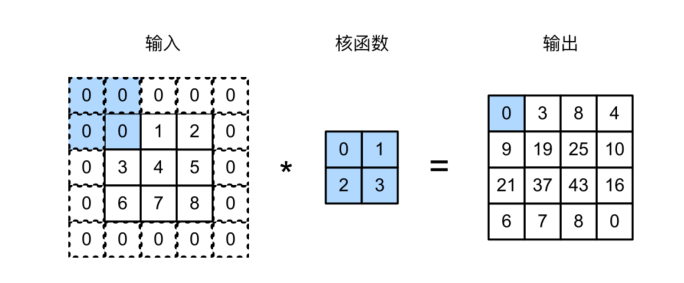

通常，如果我们添加$p_h$行填充（大约一半在顶部，一半在底部）和$p_w$列填充（左侧大约一半，右侧一半），则输出形状将为
$$
(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1)
$$
这意味着输出的高度和宽度将分别增加$p_h$和$p_w$

在许多情况下，我们需要设置$p_h=k_h-1$和$p_w=k_w-1$，使输入和输出具有相同的高度和宽度。这样可以在构建网络时更容易地预测每个图层的输出形状。假设$k_h$是奇数，我们将在高度的两侧填充$p_h/2$行。如果$k_h$是偶数，则一种可能性是在输入顶部填充$(p_h+1)/2$行，在底部填充$(p_h-1)/2$行。同理，我们填充宽度的两侧。

卷积神经⽹络中卷积核的⾼度和宽度通常为奇数，例如1、3、5或7。选择奇数的好处是，保持空间维度的同时，我们可以在顶部和底部填充相同数量的⾏，在左侧和右侧填充相同数量的列。

In [35]:
import torch
from torch import nn

# 为了方便起见，我们定义了一个计算卷积层的函数
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的(1,1)表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

In [36]:
# 请注意，这⾥每边都填充了1⾏或1列，因此总共添加了2⾏或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

发现当卷积核大小设置为(3, 3)时，padding设置为1时，能够保留原始的输入图像维度

当卷积核高度和宽度不同时，我们要想保留原始图像的维度，padding在行和列的填充上也应该不一样。例如，我们使用高度为5，宽度为3的卷积核，高度和宽度两边的填充分别为2和1.

计算方法$\frac{5-1}{2}=2$, $\frac{3-1}{2}=1$

In [39]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## 步幅

在计算互相关时，卷积窗⼝从输⼊张量的左上⻆开始，向下、向右滑动。在前⾯的例⼦中，我们默认每次滑动⼀个元素。但是，有时候为了⾼效计算或是缩减采样次数，卷积窗⼝可以跳过中间位置，每次滑动多个元素。

我们将每次滑动元素的数量称为**步幅（stride）**。

下图是垂直步幅为3，⽔平步幅为2的⼆维互相关运算。

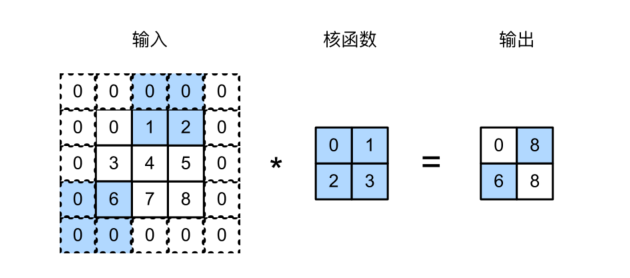

通常，当垂直步幅为$s_h$、⽔平步幅为$s_w$时，输出形状为

$$
\left \lfloor(n_h-k_h+p_h+s_h)/s_h\right \rfloor\times\left\lfloor(n_w-k_w+p_w+s_w)/s_w\right\rfloor
$$

如果我们设置了$p_h=k_h-1$和$p_w=k_w-1$，则输出形状将简化为

$$
\left \lfloor(n_h+s_h-1)/s_h\right \rfloor\times\left\lfloor(n_w+s_w-1)/s_w\right\rfloor
$$

更进一步，如果输入的高度和宽度可以被垂直和水平步幅整除，则输出形状将为

$$
(n_h/s_h)\times(n_w/s_w)
$$

下面，我们将高度和宽度的步幅设置为2，从而将输入的高度和宽度减半

In [40]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

接下来看一个稍微复杂一点的例子

In [41]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

说明:
- 当输⼊高度和宽度两侧的填充数量分别为$p_h$和$p_w$时，我们称之为填充$(p_h, p_w)$。当$p_h=p_w=p$时，填充是p。
- 当高度和宽度上步幅分别为$s_h$和$s_w$时，我们称之为步幅(s_h, s_w)。当时的步幅为$s_h=s_w=s$时，步幅为s。

默认情况下，填充为0，步幅为1。在实践中，我们很少使用不一致的步幅或填充，也就是说，我们通常有$p_h=p_w$和$s_h=s_w$。

# 多输入多输出通道

## 多输入通道

当输⼊包含多个通道时，需要构造⼀个与输⼊数据具有相同输⼊通道数的卷积核，以便与输⼊数据进⾏互相关运算。

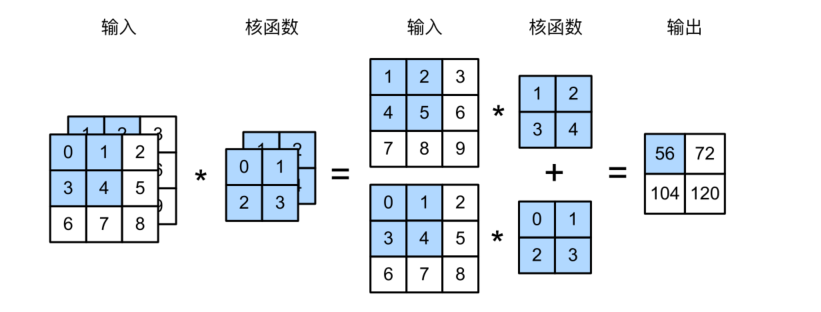

In [11]:
def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x,k) for x, k in zip(X, K))

In [43]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], 
                  [[1.0, 2.0], [3.0, 4.0]]])
corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 多输出通道

到⽬前为⽌，不论有多少输⼊通道，我们还只有⼀个输出通道。
在最流⾏的神经⽹络架构中，随着神经⽹络层数的加深，我们常会增加输出通道的维数，通过减少空间分辨率以获得更⼤的通道深度。直观地说，我们可以将每个通道看作是对不同特征的响应。⽽现实可能更为复杂⼀些，因为每个通道不是独⽴学习的，⽽是为了共同使⽤⽽优化的。

因此，多输出通道并不仅是学习多个单通道的检测器。

In [9]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

通过将核张量K与K+1（K中的每个元素加1）和K+2连接起来，构造一个具有3个输出通道的卷积核。

In [45]:
K = torch.stack((K, K+1, K+2), 0)
K.shape

torch.Size([3, 2, 2, 2])

对输⼊张量X与卷积核张量K执⾏互相关运算。

In [46]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

可以看到第一个通道与之前的结果一致。

## 1$\times$1卷积层

$1\times1$卷积，即$k_h=k_w=1$，看起来似乎没有多大意义。毕竟卷积的本质是有效提取相邻像素间的相关特征，而$1\times1$卷积显然没有此作用。尽管如此，$1\times1$仍然十分流行，经常包含在复杂深层网络的设计中。

因为使用了最小窗口，$1\times1$卷积失去了卷积层的特有能力—在高度和宽度维度上，识别相邻元素互相作用的能力。其实$1\times1$卷积的唯一计算发生在通道上。

使⽤1×1卷积核与3个输⼊通道和2个输出通道的互相关计算。这⾥输⼊和输出具有相同的⾼度
和宽度，输出中的每个元素都是从输⼊图像中同⼀位置的元素的线性组合。我们可以将1×1卷积层看作是在每个像素位置应⽤的全连接层，以$c_i$个输⼊值转换为$c_o$个输出值。因为这仍然是⼀个卷积层，所以跨像素的权重是⼀致的。同时，1×1卷积层需要的权重维度为$c_o\times c_i$，再额外加上⼀个偏置。

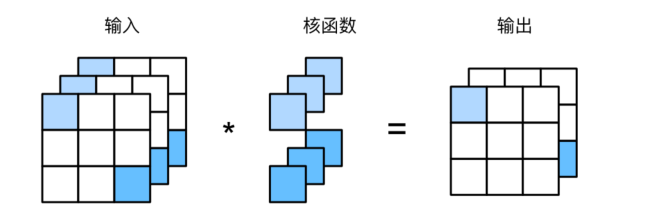

In [3]:
import torch

In [1]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中矩阵的乘法
    Y = K@X
    return Y.reshape((c_o, h, w))

In [4]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

In [7]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y1.shape

torch.Size([2, 3, 3])

In [15]:
Y2 = corr2d_multi_in_out(X, K)
Y2.shape

torch.Size([2, 3, 3])

# 汇聚层（Pooling）

通常当我们处理图像时，我们希望逐渐降低隐藏表⽰的空间分辨率、聚集信息，这样随着我们在神经⽹络中层叠的上升，每个神经元对其敏感的感受野（输⼊）就越⼤。

⽽我们的机器学习任务通常会跟全局图像的问题有关（例如，“图像是否包含⼀只猫呢？”），所以我们最后⼀层的神经元应该对整个输⼊的全局敏感。通过逐渐聚合信息，⽣成越来越粗糙的映射，最终实现学习全局表⽰的⽬标，同时将卷积图层的所有优势保留在中间层。

此外，当检测较底层的特征时（例如 6.2节中所讨论的边缘），我们通常希望这些特征保持某种程度上的平移不变性。例如，如果我们拍摄⿊⽩之间轮廓清晰的图像X，并将整个图像向右移动⼀个像素，即`Z[i, j] = X[i, j + 1]`，则新图像Z的输出可能⼤不相同。⽽在现实中，随着拍摄⻆度的移动，任何物体⼏乎不可能发⽣在同⼀像素上。即使⽤三脚架拍摄⼀个静⽌的物体，由于快⻔的移动⽽引起的相机振动，可能会使所有物体左右移动⼀个像素（除了⾼端相机配备了特殊功能来解决这个问题）。

本节将介绍汇聚（pooling）层，有时候我们也称为池化层，它具有双重⽬的：
1. 降低卷积层对位置的敏感性
2. 降低对空间降采样表⽰的敏感性。

## 最大汇聚层和平均汇聚层

与互相关运算符⼀样，汇聚窗⼝从输⼊张量的左上⻆开始，从左往右、从上往下的在输⼊张量内滑动。在汇聚窗⼝到达的每个位置，它计算该窗⼝中输⼊⼦张量的最⼤值或平均值。计算最⼤值或平均值是取决于使⽤了最⼤汇聚层还是平均汇聚层。

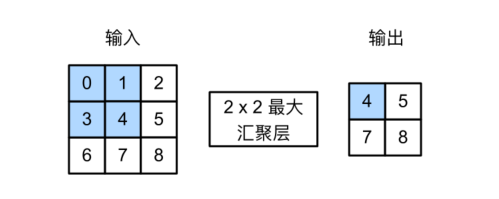

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

In [21]:
# 步长为1
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [22]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

平均汇聚层

In [23]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

## 填充和步幅

与卷积层⼀样，汇聚层也可以改变输出形状。和以前⼀样，我们可以通过填充和步幅以获得所需的输出形状。

In [24]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下。深度学习框架中的步幅与汇聚窗口的大小相同。因此，如果我们使用形状为(3, 3)的汇聚窗口，那么默认情况下，我们得到的步幅形状为(3, 3)。

In [25]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

填充和步幅可以手动设定

In [26]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

可以设定一个任意大小的矩形汇聚窗口，并分别设定填充和步幅的高度和宽度。

In [27]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## 多个通道

在处理多通道输⼊数据时，汇聚层在每个输⼊通道上单独运算，⽽不是像卷积层⼀样在通道上对输⼊进⾏汇总。这意味着汇聚层的输出通道数与输⼊通道数相同。下⾯，我们将在通道维度上连结张量X和X + 1，以构建具有2个通道的输⼊。

X四维度尺寸意义：（批量大小，通道数，高度， 宽度）

In [28]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

如下所示，汇聚后输出通道的数量仍然是2

In [33]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# 卷积神经网络（LeNet）

通过之前⼏节，我们学习了构建⼀个完整卷积神经⽹络的所需组件。回想⼀下，之前我们将softmax回归模型和多层感知机模型应⽤于Fashion-MNIST数据集中的服装图⽚。为了能够应⽤softmax回归
和多层感知机，我们⾸先将每个⼤⼩为28 × 28的图像展平为⼀个784维的固定⻓度的⼀维向量，然后⽤全连接层对其进⾏处理。⽽现在，我们已经掌握了卷积层的处理⽅法，我们可以在图像中**保留空间结构**。同时，⽤卷积层代替全连接层的另⼀个好处是：**模型更简洁、所需的参数更少**。

LeNet，它是最早发布的卷积神经⽹络之⼀，因其在计算机视觉任务中的⾼效性能⽽受到⼴泛关注。这了模型是由$AT&T$贝尔实验室的研究员$Yann LeCun$在1989年提出的（并以其命名），目的是识别图像中的手写数字。

当时，LeNet取得了与SVM性能相媲美的成果，成为监督学习的主流方法。

总体来看，LeNet（LeNet-5）由两个部分组成：
- 卷积编码器：由两个卷积层组成
- 全连接层密集块：由三个全连接层组成

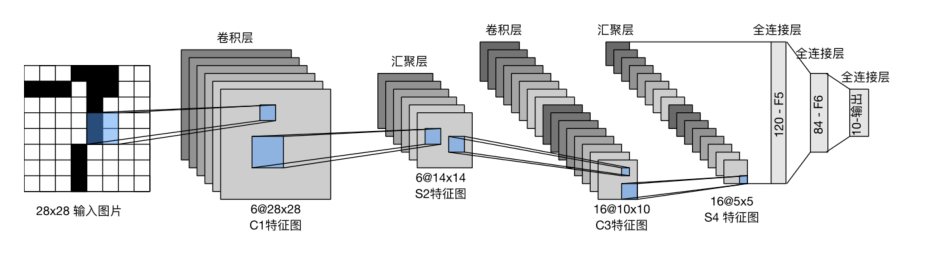

每个卷积块中的基本单元是⼀个卷积层、⼀个sigmoid激活函数和平均汇聚层。

虽然ReLU和最⼤汇聚层更有效，但它们在20世纪90年代还没有出现。

每个卷积层使⽤5 × 5卷积核和⼀个sigmoid激活函数。这些层将输⼊映射到多个⼆维特征输出，通常同时增加通道的数量。第⼀卷积层有6个输出通道，⽽第⼆个卷积层有16个输出通道。每个2 × 2池操作（步骤2）通过空间下采样将维数减少4倍。卷积的输出形状由批量⼤⼩、通道数、⾼度、宽度决定。

为了将卷积块的输出传递给稠密块，我们必须在⼩批量中展平每个样本。换⾔之，我们将这个四维输⼊转换成全连接层所期望的⼆维输⼊。这⾥的⼆维表⽰的第⼀个维度索引⼩批量中的样本，第⼆个维度给出每个样本的平⾯向量表⽰。LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执⾏分类任务，所以输出层的10维对应于最后输出结果的数量。

## 模型搭建

In [34]:
import torch
from torch import nn
from d2l import torch as d2l

In [35]:
net = nn.Sequential(
                    nn.Conv2d(1, 6, kernel_size=5, padding=2),
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5),
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120),
                    nn.Sigmoid(),
                    nn.Linear(120, 84),
                    nn.Sigmoid(),
                    nn.Linear(84, 10))

我们对原始模型做了⼀点⼩改动，去掉了最后⼀层的⾼斯激活。

打印每层形状

In [39]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


## 模型训练

In [40]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

为了进⾏评估，我们需要对evaluate_accuracy函数进⾏轻微的修改。由于完整的数据集位于内存中，因此在模型使⽤GPU计算数据集之前，我们需要将其复制到显存中。

In [44]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使⽤GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval() # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

为了使⽤GPU，我们还需要⼀点⼩改动。与train_epoch_ch3不同，在进⾏正向和反向传播之前，我们需要将每⼀⼩批量数据移动到我们指定的设备（例如GPU）上。

In [45]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """⽤GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)  # 使用xavier进行参数的初始化
    net.apply(init_weights)
    print('training on', device)
    net.to(device)  # 将模型放入GPU
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()  # 优化器梯度初始化
            X, y = X.to(device), y.to(device)  # 将数据放入GPU
            y_hat = net(X)  # 前向计算
            l = loss(y_hat, y)  # 计算损失
            l.backward()  # 反向传播，计算梯度
            optimizer.step()  # 利用梯度更新参数
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.458, train acc 0.828, test acc 0.808
41692.4 examples/sec on cuda:0


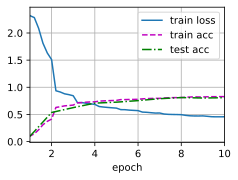

In [46]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())